https://pytorch.org/docs/stable/notes/autograd.html

How autograd encodes the history
Autograd is reverse automatic differentiation system. Conceptually, autograd records a graph recording all of the operations that created the data as you execute operations, giving you a directed acyclic graph whose leaves are the input tensors and roots are the output tensors. By tracing this graph from roots to leaves, you can automatically compute the gradients using the chain rule.

Internally, autograd represents this graph as a graph of Function objects (really expressions), which can be apply() ed to compute the result of evaluating the graph. When computing the forwards pass, autograd simultaneously performs the requested computations and builds up a graph representing the function that computes the gradient (the .grad_fn attribute of each torch.Tensor is an entry point into this graph). When the forwards pass is completed, we evaluate this graph in the backwards pass to compute the gradients.

An important thing to note is that the graph is recreated from scratch at every iteration, and this is exactly what allows for using arbitrary Python control flow statements, that can change the overall shape and size of the graph at every iteration. You don’t have to encode all possible paths before you launch the training - what you run is what you differentiate.


Setting requires_grad
requires_grad is a flag, defaulting to false unless wrapped in a nn.Parameter, that allows for fine-grained exclusion of subgraphs from gradient computation. It takes effect in both the forward and backward passes:

During the forward pass, an operation is only recorded in the backward graph if at least one of its input tensors require grad. During the backward pass (.backward()), only leaf tensors with requires_grad=True will have gradients accumulated into their .grad fields.

It is important to note that even though every tensor has this flag, setting it only makes sense for leaf tensors (tensors that do not have a grad_fn, e.g., a nn.Module’s parameters). Non-leaf tensors (tensors that do have grad_fn) are tensors that have a backward graph associated with them. Thus their gradients will be needed as an intermediary result to compute the gradient for a leaf tensor that requires grad. **From this definition, it is clear that all non-leaf tensors will automatically have require_grad=True.**  

上面的这句话是错误的。 正确的应该是，在最终的生成的有向无环图上，如果某个中间节点，对应的所有的leaf tensor 或者 其他上游tensor都是 require_grad == false，那么该 non-leaf tensor的 require_grad 也会默认是 false。 例如可以参考 下面的例子。 


[ 1.27323954e-01 -3.89817183e-17 -2.12206591e-01  3.89817183e-17
  6.36619772e-01  1.00000000e+00  6.36619772e-01  3.89817183e-17
 -2.12206591e-01 -3.89817183e-17  1.27323954e-01]
[-1.76697482e-18 -1.56756647e-18 -4.26047476e-02  1.98723786e-17
  5.40636518e-01  1.00000000e+00  5.40636518e-01  1.98723786e-17
 -4.26047476e-02 -1.56756647e-18 -1.76697482e-18]
[-8.85229747e-19 -7.85328944e-19 -2.13443845e-02  9.95578457e-18
  2.70851357e-01  5.00986056e-01  2.70851357e-01  9.95578457e-18
 -2.13443845e-02 -7.85328944e-19 -8.85229747e-19]


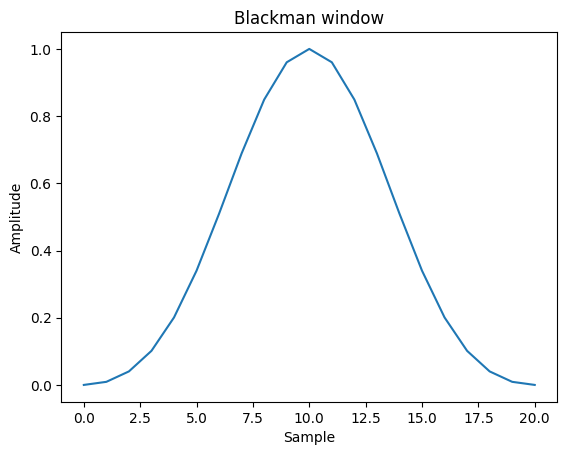

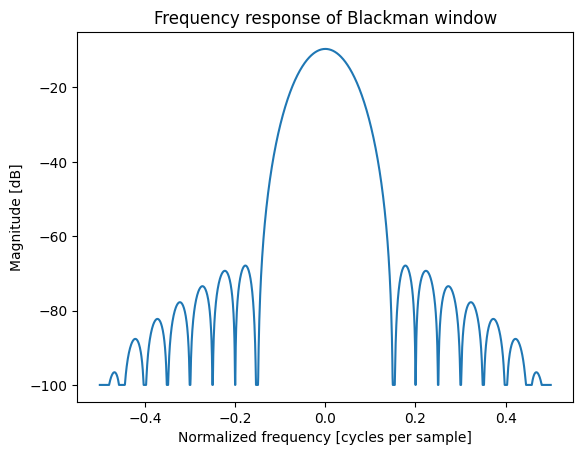

In [1]:
from __future__ import print_function
from __future__ import division

import numpy as np

# Example code, computes the coefficients of a low-pass windowed-sinc filter.

# Configuration.
fS = 8  # Sampling rate.
fL = 2  # Cutoff frequency.
N = 11  # Filter length, must be odd.

# Compute sinc filter.
h = np.sinc(2 * fL / fS * (np.arange(N) - (N - 1) / 2))

print(h)

# Apply window.
h *= np.blackman(N)

print(h)

# Normalize to get unity gain.
h /= np.sum(h)

print(h)

# Applying the filter to a signal s can be as simple as writing
# s = np.convolve(s, h)


import matplotlib.pyplot as plt
np.blackman(12)

from numpy.fft import fft, fftshift
window = np.blackman(21)
plt.plot(window)
plt.title("Blackman window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()
plt.figure()
A = fft(window, 2048) / 25.5
mag = np.abs(fftshift(A))
freq = np.linspace(-0.5, 0.5, len(A))
with np.errstate(divide='ignore', invalid='ignore'):
    response = 20 * np.log10(mag)
response = np.clip(response, -100, 100)
plt.plot(freq, response)
plt.title("Frequency response of Blackman window")
plt.ylabel("Magnitude [dB]")
plt.xlabel("Normalized frequency [cycles per sample]")
_ = plt.axis('tight')
plt.show()

In [2]:
import torch

x1 = torch.randn(5, requires_grad=True)
print(x1)

x2 = torch.randn(5)

y1 = x1.pow(x1)

y2 = x2.pow(x2)

z = y1 + y2

print("x1 requires_grad:", x1.requires_grad)
print("x2 requires_grad:", x2.requires_grad)
print("y1 requires_grad:", y1.requires_grad)
print("y2 requires_grad:", y2.requires_grad)
print("z requires_grad:", z.requires_grad)

tensor([ 0.9754, -0.2832, -0.4919,  0.9351,  0.8982], requires_grad=True)
x1 requires_grad: True
x2 requires_grad: False
y1 requires_grad: True
y2 requires_grad: False
z requires_grad: True


In [3]:
import torch

a = torch.randn(1)
print(a, a.shape)
a = a.squeeze()
print(a, a.shape)

print(type(a))

x = 1.0
print(type(x))

x += a
print(x, type(x))

tensor([-0.1521]) torch.Size([1])
tensor(-0.1521) torch.Size([])
<class 'torch.Tensor'>
<class 'float'>
tensor(0.8479) <class 'torch.Tensor'>


In [4]:
import torch
from torch import nn
from typing import Union, Tuple, Any, Callable, Iterator, Set, Optional, overload, TypeVar, Mapping, Dict, List

class MyLinear(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(in_features, out_features))
    self.bias = nn.Parameter(torch.randn(out_features))

  def forward(self, input):
    return (input @ self.weight) + self.bias

  def register_module(self, name: str, module: Optional['Module']) -> None:
    r"""Alias for :func:`add_module`."""
    self.add_module(name, module)
  def __setattr__(self, name, value):
    super().__setattr__(name, value)
    print(name, " is being added into this instance")

my = MyLinear(3, 64)
print(len(list(my.parameters())))

weight  is being added into this instance
bias  is being added into this instance
2


In [5]:
class Base1:
    def __init__(self):
        self.b = 1
        print("in base1:", id(self))
        
class Base2:
    def __init__(self):
        self.b = 1
        print("in base2:", id(self))

class Deriv(Base1, Base2):
    def __init__(self):
        super().__init__()
        self.d = 2
        print("in derived:", id(self))


d = Deriv()



in base1: 23266276255408
in derived: 23266276255408


In [3]:
import torch
from torch.distributions.normal import Normal

# 定义正态分布的均值和标准差
mean = 0.0
stddev = 0.0000001  # 标准差为 1.0

# 创建正态分布对象
normal_dist = Normal(mean, stddev)

# 计算某个值的对数概率密度
x = torch.tensor([0.0, 1.0, 2.0, -1.0, -2.0])
log_prob = normal_dist.log_prob(x)

print("Values:", x)
print("Log Probability Densities:", log_prob)

Values: tensor([ 0.,  1.,  2., -1., -2.])
Log Probability Densities: tensor([ 1.5199e+01, -5.0000e+13, -2.0000e+14, -5.0000e+13, -2.0000e+14])


In [8]:
import math
print(math.log(0.000000001))

-20.72326583694641


<md>|Entity| No confidence |Confidence
[-|-|-U.S|63 |20Lebanon|64|23Turkey| 68| 14 Tunisia|69 18Israel| 83 |6|</md>